## Preprocessing 

#### if the MR is in dicom 

In [ ]:
## place the dicom images in the data/dicom folder

## run the following command to convert the dicom images to nifti images
!python ./preprocessing/dicomtonifti_2.py -i ./data/dicom -o ./data/unprocessed


Looking for DICOM series in: /media/data/BrainIAC/src/BrainIAC/data/dicom
Found 2 potential scan directories
Converting scans: 100%|███████████████████████████| 2/2 [00:00<00:00, 15.50it/s]

Conversion Summary:
Successfully converted: 2 scans
Failed conversions: 0 scans
Output directory: /media/data/BrainIAC/src/BrainIAC/data


#### if the MRs are in nifti 

In [1]:
"""
Preprocess MRI images using the BrainIAC preprocessing pipeline.

3D MRI preprocessing includes:
- Registration to template space using the provided template image
- Skull stripping and brain extraction

Parameters:
    --temp_img: Path to template image for registration (./preprocessing/atlases/temp_head.nii.gz)
    --input_dir: Directory containing unprocessed NIfTI images (./data/sample/unprocessed)
    --output_dir: Directory to save processed images (./data/sample/processed)

Expected input: Raw NIfTI (.nii.gz) files in the input directory
Expected output: Preprocessed NIfTI files
"""

!python ./preprocessing/mri_preprocess_3d_simple.py \
--temp_img ./preprocessing/atlases/temp_head.nii.gz \
--input_dir ./data/sample/unprocessed \
--output_dir ./data/sample/processed

Starting brain MRI preprocessing...

Step 1: Image Registration
Preloading step...
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.16it/s]
Registering images...
  0%|                                                     | 0/1 [00:00<?, ?it/s]Processing image 1: I10307487
^C


## BrainIAC - Feature Extraction

In [3]:
"""
Extract BrainIAC backbone features from preprocessed MRI images.

This script uses the BrainIAC backbone (Vit-B) to extract latent
feature representations from brain MRI scans. 

Parameters:
    --checkpoint: Path to the BrainIAC checkpoint
    --input_csv: CSV file containing scan IDs and labels (format: pat_id, label)
    --output_csv: Output path for extracted features CSV file
    --root_dir: Directory containing preprocessed NIfTI images

Expected input: Preprocessed NIfTI files and corresponding CSV 
Expected output: CSV file with extracted feature vector
"""

!python get_brainiac_features.py \
    --checkpoint ./checkpoints/BrainIAC.ckpt \
    --input_csv ./data/csvs/sample.csv \
    --output_csv ./inference/features/features.csv \
    --root_dir ./data/sample/processed

Backbone weights loaded!!
Extracting ViT features:   0%|                         | 0/1 [00:00<?, ?batch/s]/home/ssim0068/miniconda3/envs/brainiac/lib/python3.9/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Extracting ViT features: 100%|█████████████████| 1/1 [00:01<00:00,  1.82s/batch]
ViT BrainIAC features saved to ./inference/features/features.csv
Feature shape: (1, 769)
Number of feature dimensions: 768


## BrainIAC - Saliency map geneation 

In [4]:
"""
Generate saliency maps using the BrainIAC backbone, from the last attention layer.

Parameters:
    --checkpoint: Path to the BrainIAC checkpoint
    --input_csv: CSV file containing scan IDs and labels (format: pat_id, label)
    --output_dir: Directory to save generated saliency maps
    --root_dir: Directory containing preprocessed NIfTI images

Expected input: Preprocessed NIfTI files and corresponding CSV
Expected output: Saliency map NIfTI files 
"""

!python get_brainiac_saliencymap.py \
    --checkpoint ./checkpoints/BrainIAC.ckpt \
    --input_csv ./data/csvs/sample.csv \
    --output_dir ./inference/saliency_maps \
    --root_dir ./data/sample/processed

Backbone weights loaded!!
Generating ViT attention maps: 100%|██████████████| 1/1 [00:02<00:00,  2.83s/it]
ViT attention-based saliency maps generated and saved to ./inference/saliency_maps


### visualize the saliency map 

(96, 96, 96) (96, 96, 96) 5.619168758392334 1.0


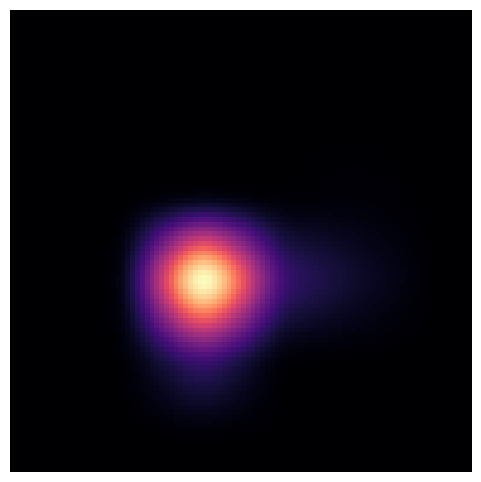

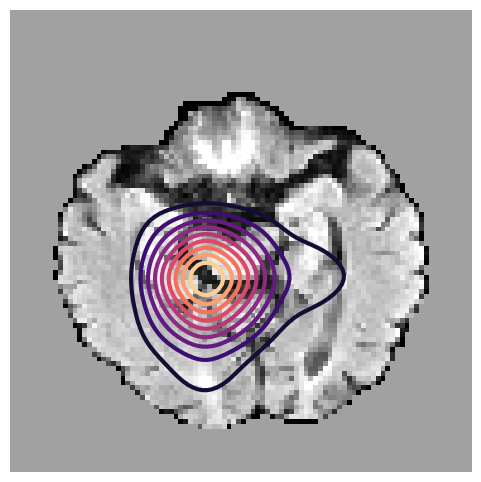

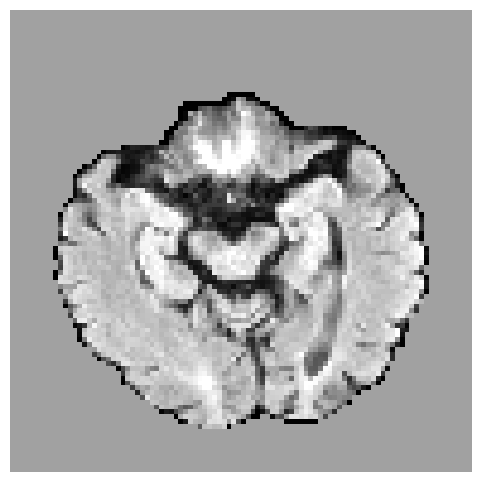

In [4]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the NIfTI files 
mri_nifti_path = f'./inference/saliency_maps/sample_0000_label_0.00_image.nii.gz' 
saliency_nifti_path = f'./inference/saliency_maps/sample_0000_label_0.00_saliencymap_layer-1.nii.gz'

mri_img = nib.load(mri_nifti_path)
saliency_img = nib.load(saliency_nifti_path)
mri_data = mri_img.get_fdata()
saliency_data = saliency_img.get_fdata()

print(mri_data.shape, saliency_data.shape, np.max(mri_data), np.max(saliency_data))

# Select a 2D slice based on a index number 
slice_idx = mri_data.shape[2] // 2 -15
mri_slice = mri_data[:, :, slice_idx]
saliency_slice = saliency_data[:, :, slice_idx]

# Normalize the MRI slice using robust normalization (1st and 99th percentiles)
def normalize_image(img):
    p1, p99 = np.percentile(img, (1, 99))
    img_clipped = np.clip(img, p1, p99)
    img_normalized = (img_clipped - p1) / (p99 - p1)
    return img_normalized

mri_slice_norm = normalize_image(mri_slice)

# Normalization function 
def normalize_saliency(saliency):
    saliency[saliency < 0] = 0
    if np.max(saliency) > 0:
        saliency_normalized = saliency / np.max(saliency)
    else:
        saliency_normalized = saliency
    return saliency_normalized

# Apply Gaussian blur to smooth the saliency map and normalize
saliency_slice_blurred = cv2.GaussianBlur(saliency_slice, (15, 15), 0)
saliency_slice_norm = normalize_saliency(saliency_slice_blurred)

# Apply a threshold to the saliency map
threshold_value = 0.0 
saliency_slice_thresholded = np.where(saliency_slice_norm > threshold_value, saliency_slice_norm, 0)

#  thresholded saliency map
plt.figure(figsize=(6, 6))
plt.imshow(saliency_slice_thresholded.T, cmap='magma', interpolation='none', origin='lower')
plt.axis('off')  

#  MRI slice with contour overlay of the thresholded saliency map
plt.figure(figsize=(6, 6))
plt.imshow(mri_slice_norm.T, cmap='gray', interpolation='none', origin='lower')
plt.contour(saliency_slice_thresholded.T, levels=10, cmap='magma', origin='lower', linewidths=3)  # Adjust the linewidth value as needed
plt.axis('off')  # Remove axis for better visualization


#  MRI slice alone (no overlay)
plt.figure(figsize=(6, 6))
plt.imshow(mri_slice_norm.T, cmap='gray', interpolation='none', origin='lower')
plt.axis('off') 


plt.show()  


# Visualize processed files

Visualizing NIfTI file with multiple views...
Image shape: (197, 233, 189)
Image data type: float64
Image value range: 0.000 to 2310.846


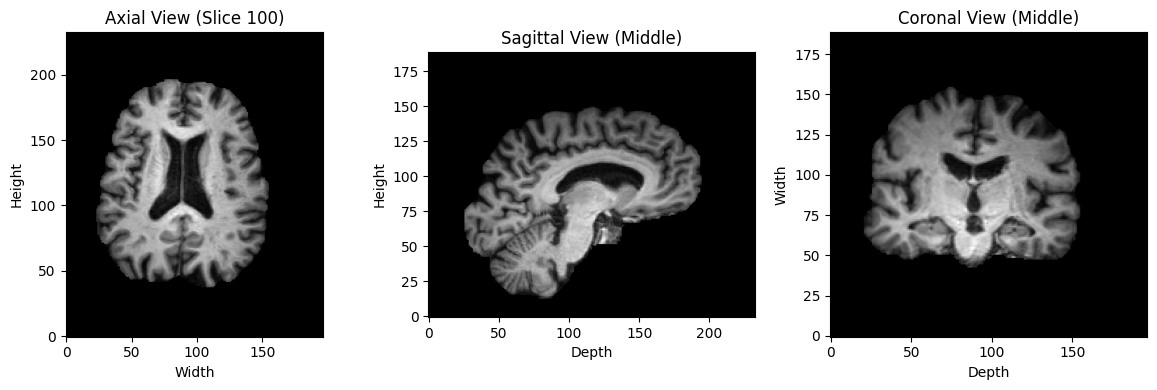


Visualizing single axial slice...


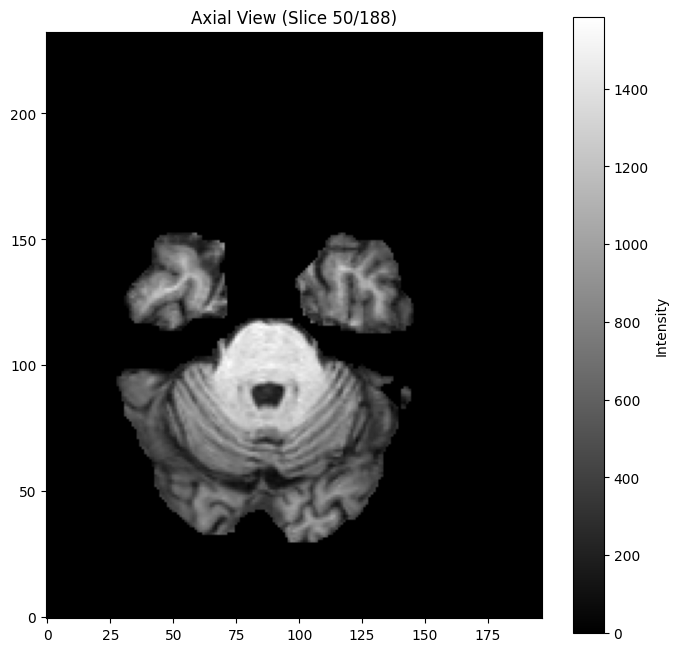

In [2]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os

def visualize_nifti(image_path, slice_idx=None, figsize=(12, 4), save_path=None):
    """
    Visualize a NIfTI file using matplotlib
    
    Args:
        image_path (str): Path to the NIfTI file (.nii.gz)
        slice_idx (int, optional): Index of the slice to display. If None, shows middle slice
        figsize (tuple): Figure size (width, height)
        save_path (str, optional): Path to save the plot. If None, displays the plot
    
    Returns:
        numpy.ndarray: The image data
    """
    
    # Check if file exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")
    
    # Load the NIfTI image
    img = nib.load(image_path)
    data = img.get_fdata()
    
    print(f"Image shape: {data.shape}")
    print(f"Image data type: {data.dtype}")
    print(f"Image value range: {data.min():.3f} to {data.max():.3f}")
    
    # Get image dimensions
    height, width, depth = data.shape
    
    # If no slice specified, use middle slice
    if slice_idx is None:
        slice_idx = depth // 2
    
    # Ensure slice index is valid
    slice_idx = max(0, min(slice_idx, depth - 1))
    
    # Extract the slice
    slice_data = data[:, :, slice_idx]
    
    # Create the plot
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Axial view (top-down)
    axes[0].imshow(slice_data.T, cmap='gray', origin='lower')
    axes[0].set_title(f'Axial View (Slice {slice_idx})')
    axes[0].set_xlabel('Width')
    axes[0].set_ylabel('Height')
    
    # Sagittal view (side view)
    sagittal_slice = data[height//2, :, :]
    axes[1].imshow(sagittal_slice.T, cmap='gray', origin='lower')
    axes[1].set_title('Sagittal View (Middle)')
    axes[1].set_xlabel('Depth')
    axes[1].set_ylabel('Height')
    
    # Coronal view (front view)
    coronal_slice = data[:, width//2, :]
    axes[2].imshow(coronal_slice.T, cmap='gray', origin='lower')
    axes[2].set_title('Coronal View (Middle)')
    axes[2].set_xlabel('Depth')
    axes[2].set_ylabel('Width')
    
    # Add colorbar
    for ax in axes:
        ax.set_aspect('equal')
    
    plt.tight_layout()
    
    # Save or display
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    else:
        plt.show()
    
    return data

def visualize_nifti_single_slice(image_path, slice_idx=None, view='axial', figsize=(8, 8), save_path=None):
    """
    Visualize a single slice of a NIfTI file
    
    Args:
        image_path (str): Path to the NIfTI file (.nii.gz)
        slice_idx (int, optional): Index of the slice to display
        view (str): View type - 'axial', 'sagittal', or 'coronal'
        figsize (tuple): Figure size
        save_path (str, optional): Path to save the plot
    
    Returns:
        numpy.ndarray: The slice data
    """
    
    # Load the NIfTI image
    img = nib.load(image_path)
    data = img.get_fdata()
    
    height, width, depth = data.shape
    
    # Get the appropriate slice based on view
    if view.lower() == 'axial':
        if slice_idx is None:
            slice_idx = depth // 2
        slice_idx = max(0, min(slice_idx, depth - 1))
        slice_data = data[:, :, slice_idx]
        title = f'Axial View (Slice {slice_idx}/{depth-1})'
        
    elif view.lower() == 'sagittal':
        if slice_idx is None:
            slice_idx = height // 2
        slice_idx = max(0, min(slice_idx, height - 1))
        slice_data = data[slice_idx, :, :]
        title = f'Sagittal View (Slice {slice_idx}/{height-1})'
        
    elif view.lower() == 'coronal':
        if slice_idx is None:
            slice_idx = width // 2
        slice_idx = max(0, min(slice_idx, width - 1))
        slice_data = data[:, slice_idx, :]
        title = f'Coronal View (Slice {slice_idx}/{width-1})'
    
    else:
        raise ValueError("View must be 'axial', 'sagittal', or 'coronal'")
    
    # Create the plot
    plt.figure(figsize=figsize)
    plt.imshow(slice_data.T, cmap='gray', origin='lower')
    plt.title(title)
    plt.colorbar(label='Intensity')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    else:
        plt.show()
    
    return slice_data

# Example usage
if __name__ == "__main__":
    # Example usage
    # image_path = "./data/sample/processed/00001_t2f.nii.gz"
    # image_path = "./data/sample/processed/I10307487_0000.nii.gz"
    # image_path = "./preprocessing/atlases/temp_head.nii.gz"
    # image_path =  "/home/ssim0068/data/ADNI/nifti/002_S_0559/MPRAGE_SENS/2006-06-27_18_28_33.0/2006-06-27_18_28_33.0.nii.gz"
    image_path = "/home/ssim0068/data/ADNI/preprocessed/MPRAGE_SENS/2006-06-27_18_39_53.0/2006-06-27_18_39_53.0.nii.gz"
    
    try:
        # Visualize with multiple views
        print("Visualizing NIfTI file with multiple views...")
        data = visualize_nifti(image_path, slice_idx=100)
        
        # Visualize single slice
        print("\nVisualizing single axial slice...")
        slice_data = visualize_nifti_single_slice(image_path, slice_idx=50, view='axial')
        
    except FileNotFoundError:
        print(f"File not found: {image_path}")
        print("Please update the image_path variable with a valid NIfTI file path.")


In [ ]:

# Example usage
if __name__ == "__main__":
    # Example usage
    # image_path = "./data/sample/processed/00001_t2f.nii.gz"
    # image_path = "./data/sample/processed/I10307487_0000.nii.gz"
    # image_path = "./preprocessing/atlases/temp_head.nii.gz"
    # image_path =  "/home/ssim0068/data/ADNI/nifti/002_S_0559/MPRAGE_SENS/2006-06-27_18_28_33.0/2006-06-27_18_28_33.0.nii.gz"
    image_path = "/home/ssim0068/data/ADNI/preprocessed/temp_reg/2006-05-19_16_29_07.0_0000.nii.gz"
    
    try:
        # Visualize with multiple views
        print("Visualizing NIfTI file with multiple views...")
        data = visualize_nifti(image_path, slice_idx=50)
        
        # Visualize single slice
        print("\nVisualizing single axial slice...")
        slice_data = visualize_nifti_single_slice(image_path, slice_idx=50, view='axial')
        
    except FileNotFoundError:
        print(f"File not found: {image_path}")
        print("Please update the image_path variable with a valid NIfTI file path.")


# Compare preprocessed image with original image

In [8]:
def compare_preprocessing_separate(image_path_before, image_path_after, slice_idx=None, view='axial', figsize=(20, 8), save_path=None):
    """
    Compare images before and after preprocessing with separate plots (handles different shapes better)
    
    Args:
        image_path_before (str): Path to the original NIfTI file
        image_path_after (str): Path to the preprocessed NIfTI file
        slice_idx (int, optional): Index of the slice to display
        view (str): View type - 'axial', 'sagittal', or 'coronal'
        figsize (tuple): Figure size (width, height)
        save_path (str, optional): Path to save the comparison plot
    
    Returns:
        tuple: (before_data, after_data) - the image data arrays
    """
    
    # Check if both files exist
    if not os.path.exists(image_path_before):
        raise FileNotFoundError(f"Before image file not found: {image_path_before}")
    if not os.path.exists(image_path_after):
        raise FileNotFoundError(f"After image file not found: {image_path_after}")
    
    # Load both images
    img_before = nib.load(image_path_before)
    img_after = nib.load(image_path_after)
    
    data_before = img_before.get_fdata()
    data_after = img_after.get_fdata()
    
    print(f"Before preprocessing:")
    print(f"  Shape: {data_before.shape}")
    print(f"  Data type: {data_before.dtype}")
    print(f"  Value range: {data_before.min():.3f} to {data_before.max():.3f}")
    
    print(f"\nAfter preprocessing:")
    print(f"  Shape: {data_after.shape}")
    print(f"  Data type: {data_after.dtype}")
    print(f"  Value range: {data_after.min():.3f} to {data_after.max():.3f}")
    
    height_before, width_before, depth_before = data_before.shape
    height_after, width_after, depth_after = data_after.shape
    
    # Get the appropriate slice based on view
    if view.lower() == 'axial':
        if slice_idx is None:
            slice_idx_before = depth_before // 2
            slice_idx_after = depth_after // 2
        else:
            slice_idx_before = max(0, min(slice_idx, depth_before - 1))
            slice_idx_after = max(0, min(slice_idx, depth_after - 1))
        slice_before = data_before[:, :, slice_idx_before]
        slice_after = data_after[:, :, slice_idx_after]
        title_before = f'Before Preprocessing (Slice {slice_idx_before})'
        title_after = f'After Preprocessing (Slice {slice_idx_after})'
        
    elif view.lower() == 'sagittal':
        if slice_idx is None:
            slice_idx_before = height_before // 2
            slice_idx_after = height_after // 2
        else:
            slice_idx_before = max(0, min(slice_idx, height_before - 1))
            slice_idx_after = max(0, min(slice_idx, height_after - 1))
        slice_before = data_before[slice_idx_before, :, :]
        slice_after = data_after[slice_idx_after, :, :]
        title_before = f'Before Preprocessing (Slice {slice_idx_before})'
        title_after = f'After Preprocessing (Slice {slice_idx_after})'
        
    elif view.lower() == 'coronal':
        if slice_idx is None:
            slice_idx_before = width_before // 2
            slice_idx_after = width_after // 2
        else:
            slice_idx_before = max(0, min(slice_idx, width_before - 1))
            slice_idx_after = max(0, min(slice_idx, width_after - 1))
        slice_before = data_before[:, slice_idx_before, :]
        slice_after = data_after[:, slice_idx_after, :]
        title_before = f'Before Preprocessing (Slice {slice_idx_before})'
        title_after = f'After Preprocessing (Slice {slice_idx_after})'
    
    else:
        raise ValueError("View must be 'axial', 'sagittal', or 'coronal'")
    
    # Create the comparison plot with separate subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Before preprocessing
    im1 = axes[0, 0].imshow(slice_before.T, cmap='gray', origin='lower')
    axes[0, 0].set_title(title_before)
    axes[0, 0].set_xlabel('Width')
    axes[0, 0].set_ylabel('Height')
    axes[0, 0].set_aspect('equal')
    plt.colorbar(im1, ax=axes[0, 0], label='Intensity')
    
    # After preprocessing
    im2 = axes[0, 1].imshow(slice_after.T, cmap='gray', origin='lower')
    axes[0, 1].set_title(title_after)
    axes[0, 1].set_xlabel('Width')
    axes[0, 1].set_ylabel('Height')
    axes[0, 1].set_aspect('equal')
    plt.colorbar(im2, ax=axes[0, 1], label='Intensity')
    
    # Show shape information
    axes[1, 0].text(0.1, 0.5, f'Before Shape: {slice_before.shape}\nAfter Shape: {slice_after.shape}', 
                    transform=axes[1, 0].transAxes, fontsize=12, verticalalignment='center')
    axes[1, 0].set_title('Image Information')
    axes[1, 0].axis('off')
    
    # Show intensity histograms
    axes[1, 1].hist(slice_before.flatten(), bins=50, alpha=0.7, label='Before', density=True)
    axes[1, 1].hist(slice_after.flatten(), bins=50, alpha=0.7, label='After', density=True)
    axes[1, 1].set_title('Intensity Distribution')
    axes[1, 1].set_xlabel('Intensity')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].legend()
    
    plt.tight_layout()
    
    # Save or display
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Comparison plot saved to: {save_path}")
    else:
        plt.show()
    
    return data_before, data_after


=== Method 1: Side-by-side comparison with difference image ===
Before preprocessing:
  Shape: (256, 256, 170)
  Data type: float64
  Value range: 0.000 to 4305.022

After preprocessing:
  Shape: (197, 233, 189)
  Data type: float64
  Value range: 0.000 to 2595.318
Resizing images to common dimensions for comparison...
Cropped to common size: (197, 233)


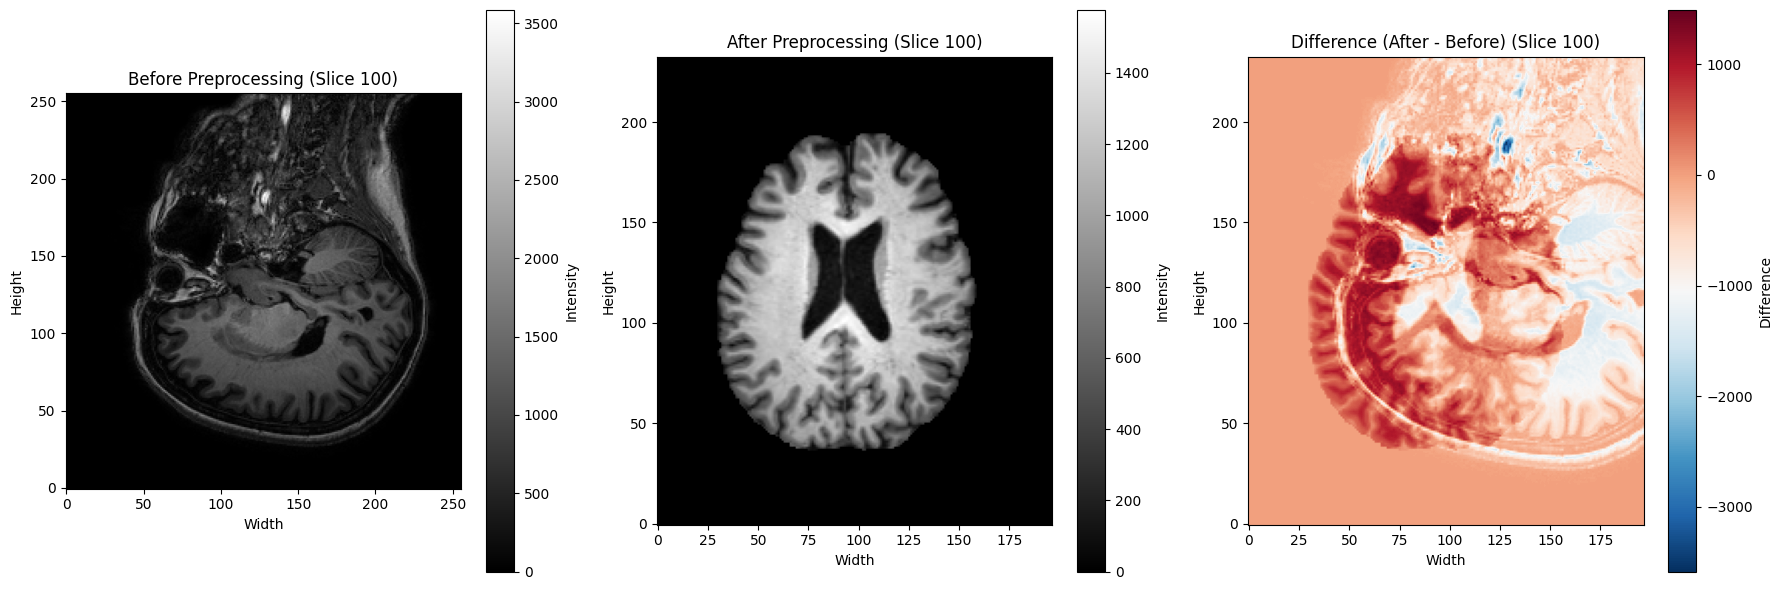


Difference Statistics:
  Mean difference: -137.924
  Std difference: 555.503
  Min difference: -3584.486
  Max difference: 1491.397

=== Method 2: Separate comparison with additional analysis ===
Before preprocessing:
  Shape: (256, 256, 170)
  Data type: float64
  Value range: 0.000 to 4305.022

After preprocessing:
  Shape: (197, 233, 189)
  Data type: float64
  Value range: 0.000 to 2595.318


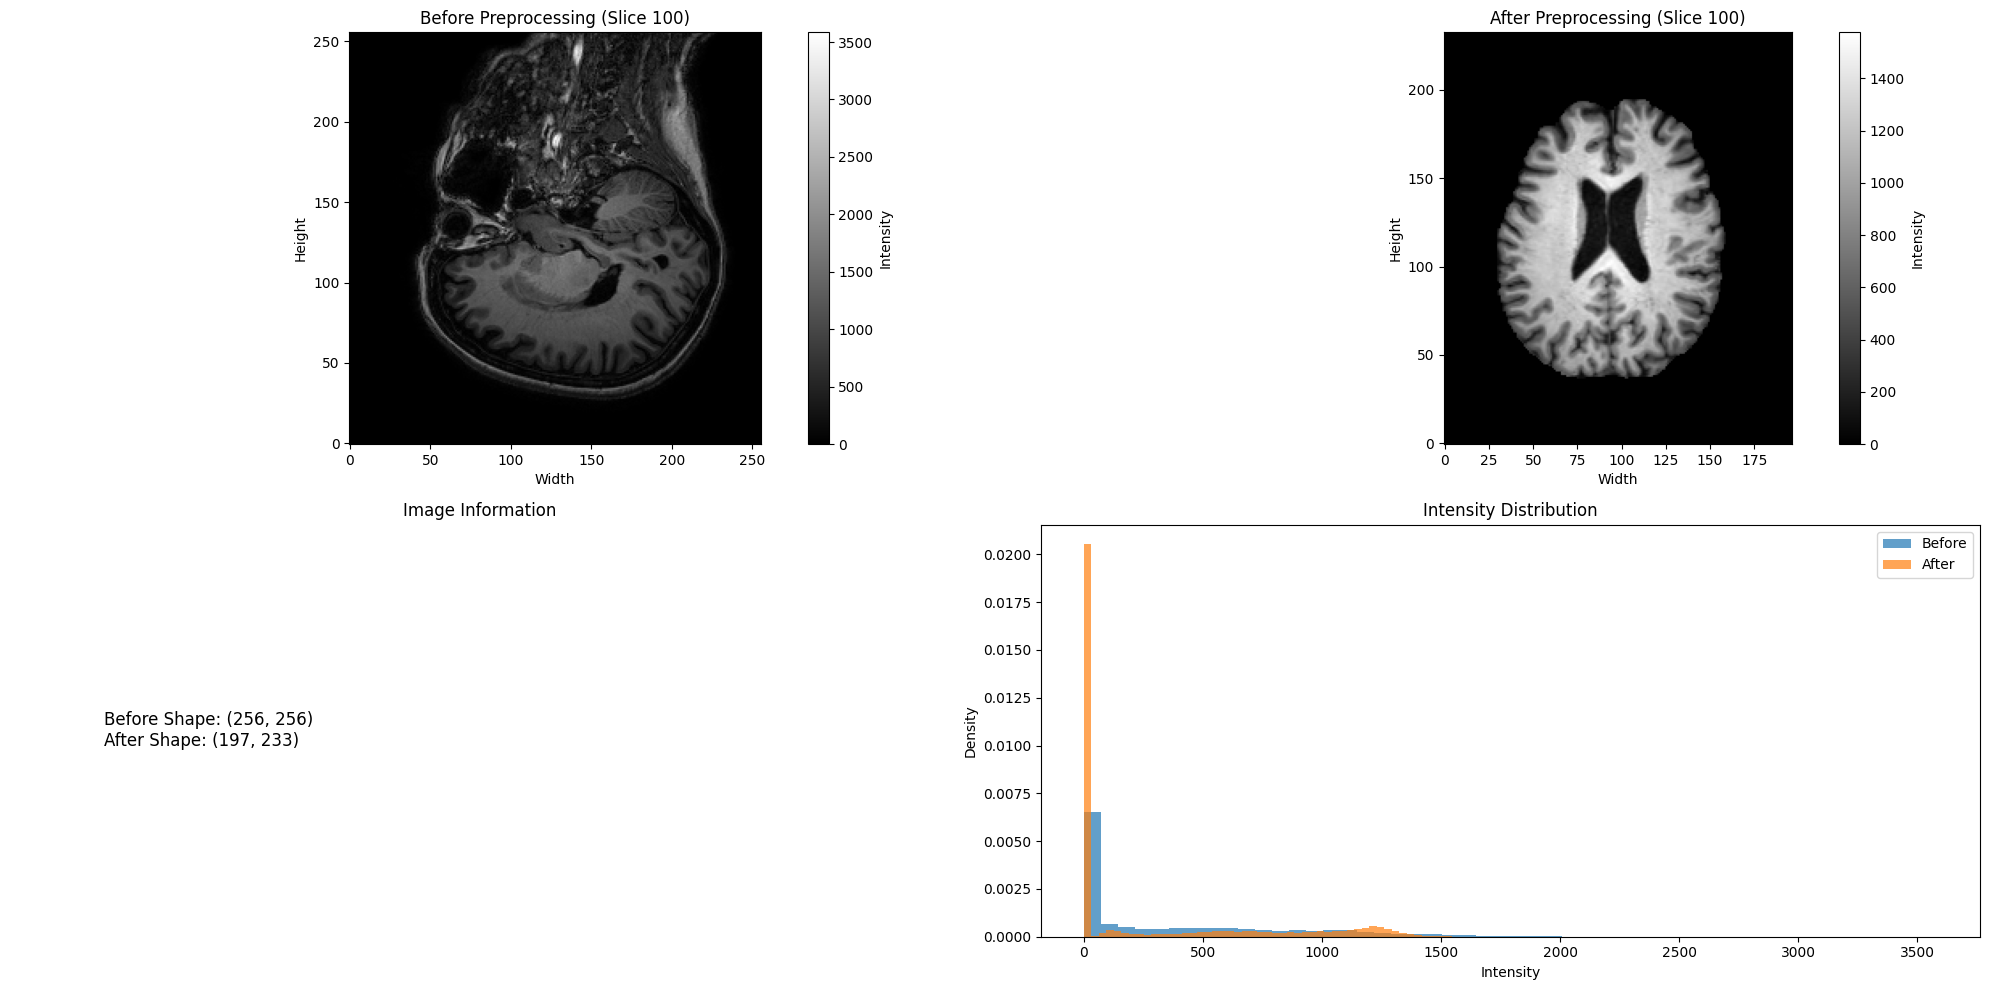

In [9]:
def compare_preprocessing(image_path_before, image_path_after, slice_idx=None, view='axial', figsize=(16, 8), save_path=None):
    """
    Compare images before and after preprocessing side by side
    
    Args:
        image_path_before (str): Path to the original NIfTI file
        image_path_after (str): Path to the preprocessed NIfTI file
        slice_idx (int, optional): Index of the slice to display
        view (str): View type - 'axial', 'sagittal', or 'coronal'
        figsize (tuple): Figure size (width, height)
        save_path (str, optional): Path to save the comparison plot
    
    Returns:
        tuple: (before_data, after_data) - the image data arrays
    """
    
    # Check if both files exist
    if not os.path.exists(image_path_before):
        raise FileNotFoundError(f"Before image file not found: {image_path_before}")
    if not os.path.exists(image_path_after):
        raise FileNotFoundError(f"After image file not found: {image_path_after}")
    
    # Load both images
    img_before = nib.load(image_path_before)
    img_after = nib.load(image_path_after)
    
    data_before = img_before.get_fdata()
    data_after = img_after.get_fdata()
    
    print(f"Before preprocessing:")
    print(f"  Shape: {data_before.shape}")
    print(f"  Data type: {data_before.dtype}")
    print(f"  Value range: {data_before.min():.3f} to {data_before.max():.3f}")
    
    print(f"\nAfter preprocessing:")
    print(f"  Shape: {data_after.shape}")
    print(f"  Data type: {data_after.dtype}")
    print(f"  Value range: {data_after.min():.3f} to {data_after.max():.3f}")
    
    height_before, width_before, depth_before = data_before.shape
    height_after, width_after, depth_after = data_after.shape
    
    # Get the appropriate slice based on view
    if view.lower() == 'axial':
        if slice_idx is None:
            slice_idx = min(depth_before, depth_after) // 2
        slice_idx = max(0, min(slice_idx, min(depth_before, depth_after) - 1))
        slice_before = data_before[:, :, slice_idx]
        slice_after = data_after[:, :, slice_idx]
        title_suffix = f' (Slice {slice_idx})'
        
    elif view.lower() == 'sagittal':
        if slice_idx is None:
            slice_idx = min(height_before, height_after) // 2
        slice_idx = max(0, min(slice_idx, min(height_before, height_after) - 1))
        slice_before = data_before[slice_idx, :, :]
        slice_after = data_after[slice_idx, :, :]
        title_suffix = f' (Slice {slice_idx})'
        
    elif view.lower() == 'coronal':
        if slice_idx is None:
            slice_idx = min(width_before, width_after) // 2
        slice_idx = max(0, min(slice_idx, min(width_before, width_after) - 1))
        slice_before = data_before[:, slice_idx, :]
        slice_after = data_after[:, slice_idx, :]
        title_suffix = f' (Slice {slice_idx})'
    
    else:
        raise ValueError("View must be 'axial', 'sagittal', or 'coronal'")
    
    # Create the comparison plot
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Before preprocessing
    im1 = axes[0].imshow(slice_before.T, cmap='gray', origin='lower')
    axes[0].set_title(f'Before Preprocessing{title_suffix}')
    axes[0].set_xlabel('Width')
    axes[0].set_ylabel('Height')
    axes[0].set_aspect('equal')
    
    # After preprocessing
    im2 = axes[1].imshow(slice_after.T, cmap='gray', origin='lower')
    axes[1].set_title(f'After Preprocessing{title_suffix}')
    axes[1].set_xlabel('Width')
    axes[1].set_ylabel('Height')
    axes[1].set_aspect('equal')
    
    # Difference image (after - before)
    # Handle different image shapes by resizing to common dimensions
    if slice_before.shape != slice_after.shape:
        print(f"Warning: Image shapes differ - Before: {slice_before.shape}, After: {slice_after.shape}")
        print("Resizing images to common dimensions for comparison...")
        
        # Use the smaller dimensions to avoid interpolation artifacts
        min_height = min(slice_before.shape[0], slice_after.shape[0])
        min_width = min(slice_before.shape[1], slice_after.shape[1])
        
        # Crop both images to the same size
        slice_before_crop = slice_before[:min_height, :min_width]
        slice_after_crop = slice_after[:min_height, :min_width]
        
        difference = slice_after_crop - slice_before_crop
        
        # Update the displayed slices to match
        slice_before = slice_before_crop
        slice_after = slice_after_crop
        
        print(f"Cropped to common size: {slice_before.shape}")
    else:
        difference = slice_after - slice_before
    
    im3 = axes[2].imshow(difference.T, cmap='RdBu_r', origin='lower')
    axes[2].set_title(f'Difference (After - Before){title_suffix}')
    axes[2].set_xlabel('Width')
    axes[2].set_ylabel('Height')
    axes[2].set_aspect('equal')
    
    # Add colorbars
    plt.colorbar(im1, ax=axes[0], label='Intensity')
    plt.colorbar(im2, ax=axes[1], label='Intensity')
    plt.colorbar(im3, ax=axes[2], label='Difference')
    
    plt.tight_layout()
    
    # Save or display
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Comparison plot saved to: {save_path}")
    else:
        plt.show()
    
    # Print some statistics
    print(f"\nDifference Statistics:")
    print(f"  Mean difference: {difference.mean():.3f}")
    print(f"  Std difference: {difference.std():.3f}")
    print(f"  Min difference: {difference.min():.3f}")
    print(f"  Max difference: {difference.max():.3f}")
    
    return data_before, data_after


# Define paths
image_before = "/home/ssim0068/data/ADNI/nifti/002_S_0413/MPRAGE_REPE/2006-05-19_16_29_07.0/2006-05-19_16_29_07.0.nii.gz"
image_after = "/home/ssim0068/data/ADNI/preprocessed/002_S_0413/MPRAGE_REPE/2006-05-19_16_29_07.0/2006-05-19_16_29_07.0.nii.gz"

# Method 1: Try the original comparison function (with shape handling)
try:
    print("=== Method 1: Side-by-side comparison with difference image ===")
    before_data, after_data = compare_preprocessing(
        image_path_before=image_before,
        image_path_after=image_after,
        slice_idx=100,  # Show slice 100
        view='axial',    # Axial view
        figsize=(18, 6), # Larger figure for better visibility
        save_path=None   # Display instead of saving
    )
except Exception as e:
    print(f"Method 1 failed: {e}")
    print("Trying Method 2...")

# Method 2: Use the separate comparison function (handles different shapes better)
try:
    print("\n=== Method 2: Separate comparison with additional analysis ===")
    before_data, after_data = compare_preprocessing_separate(
        image_path_before=image_before,
        image_path_after=image_after,
        slice_idx=100,  # Show slice 100
        view='axial',    # Axial view
        figsize=(20, 10), # Larger figure for better visibility
        save_path=None   # Display instead of saving
    )
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Make sure the preprocessing has completed and the files exist.")
except Exception as e:
    print(f"Unexpected error: {e}")
